In [1]:
import optuna as opt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
#from twilio.rest import Client
import pickle

import time

import sys
import os 


sys.path.append('../../pscapes')
sys.path.append('../../nk-ml-2024/')


from torch.utils.data import DataLoader
from pscapes.landscape_class import ProteinLandscape
from pscapes.utils import dict_to_np_array, np_array_to_dict

from src.architectures import SequenceRegressionCNN, SequenceRegressionLinear, SequenceRegressionMLP, SequenceRegressionLSTM, SequenceRegressionTransformer

from src.ml_utils import train_val_test_split_ohe, landscapes_ohe_to_numpy
from src.hyperopt import objective_NK, sklearn_objective_NK

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor 

from src.train_utils import train_models_from_hparams_NK, read_MLP_hparams, read_CNN_hparams, read_LSTM_hparams, read_transformer_hparams, instantiate_model_from_study

from src.analysis import get_latent_representation
import matplotlib.pyplot as plt
from sklearn.neighbors import kneighbors_graph
import math
import networkx as nx
from scipy.sparse import diags

import torchmetrics
from torchmetrics.regression import SpearmanCorrCoef, PearsonCorrCoef


/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ubuntu/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
#set global parameters
HPARAM_PATH = '../hyperopt/results/NK_hyperopt_results.pkl'
DATA_PATH = '../data/nk_landscapes/'
MODEL_SAVEPATH = '../models/'
RESULT_PATH = '../results/NK_train_test_results.pkl'
SEQ_LEN = 6
AA_ALPHABET  = 'ACDEFG'
N_REPLICATES = 4

In [3]:
#load landscapes
#load landscape data 
landscapes = []
print('Loading landscapes.')
for k in range(SEQ_LEN):
    replicate_list = []
    for r in range(N_REPLICATES):
        landscape = ProteinLandscape(csv_path=DATA_PATH+'/k{0}_r{1}.csv'.format(k,r), amino_acids=AA_ALPHABET)
        replicate_list.append(landscape)
    landscapes.append(replicate_list)
landscapes = [[i.fit_OHE() for i in j] for j in landscapes]

print('Calculating train-test-val splits')
splits = [train_val_test_split_ohe(i, random_state=1) for i in landscapes]
#landscapes_ohe, xy_train, xy_val, xy_test, x_tests, y_tests = splits[k_index] 

Loading landscapes.
Calculating train-test-val splits


In [4]:
#load hparam studies 
with open(HPARAM_PATH, 'rb') as handle: 
    NK_hparams = pickle.load(handle)

In [5]:
model_names = ['linear', 'mlp', 'cnn', 'ulstm', _]


## Test set performance

In [6]:
#instantiate models with the correct hyperparameters from hparam optimisation
linear_models = [[instantiate_model_from_study('linear', i) for r in range(N_REPLICATES)] for i in NK_hparams['linear']]
mlp_models    = [[instantiate_model_from_study('mlp', i) for r in range(N_REPLICATES)] for i in NK_hparams['mlp']]
cnn_models    = [[instantiate_model_from_study('cnn', i) for r in range(N_REPLICATES)] for i in NK_hparams['cnn']]
ulstm_models   = [[instantiate_model_from_study('ulstm', i) for r in range(N_REPLICATES)] for i in NK_hparams['ulstm']]
#cnn_models = [[instantiate_model_from_study('cnn', i)] for i in NK_hparams['cnn']] 
#ulstm_models = [[instantiate_model_from_study('ulstm', i)] for i in NK_hparams['ulstm']] 

[W1108 06:41:34.838781365 NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.


In [7]:
#load model parameters 
[[linear_models[k_val][replicate].load_state_dict(torch.load(MODEL_SAVEPATH+'{}_NK_k{}_r{}.pt'.format('linear', k_val, replicate), weights_only=True)) 
  for replicate in range(N_REPLICATES)] for k_val in range(SEQ_LEN)] #load weights
[[mlp_models[k_val][replicate].load_state_dict(torch.load(MODEL_SAVEPATH+'{}_NK_k{}_r{}.pt'.format('mlp', k_val, replicate), weights_only=True)) 
  for replicate in range(N_REPLICATES)] for k_val in range(SEQ_LEN)]
[[cnn_models[k_val][replicate].load_state_dict(torch.load(MODEL_SAVEPATH+'{}_NK_k{}_r{}.pt'.format('cnn', k_val, replicate), weights_only=True)) 
  for replicate in range(N_REPLICATES)] for k_val in range(SEQ_LEN)]
[[ulstm_models[k_val][replicate].load_state_dict(torch.load(MODEL_SAVEPATH+'{}_NK_k{}_r{}.pt'.format('ulstm', k_val, replicate), weights_only=True)) 
  for replicate in range(N_REPLICATES)] for k_val in range(SEQ_LEN)]

[[<All keys matched successfully>,
  <All keys matched successfully>,
  <All keys matched successfully>,
  <All keys matched successfully>],
 [<All keys matched successfully>,
  <All keys matched successfully>,
  <All keys matched successfully>,
  <All keys matched successfully>],
 [<All keys matched successfully>,
  <All keys matched successfully>,
  <All keys matched successfully>,
  <All keys matched successfully>],
 [<All keys matched successfully>,
  <All keys matched successfully>,
  <All keys matched successfully>,
  <All keys matched successfully>],
 [<All keys matched successfully>,
  <All keys matched successfully>,
  <All keys matched successfully>,
  <All keys matched successfully>],
 [<All keys matched successfully>,
  <All keys matched successfully>,
  <All keys matched successfully>,
  <All keys matched successfully>]]

In [8]:
models_dict = {'linear': linear_models, 'mlp': mlp_models, 'cnn':cnn_models, 'ulstm': ulstm_models}

In [9]:
from sklearn.metrics import r2_score


In [10]:
#evaluate models
device = 'cpu'
results = {}
loss_fn = nn.MSELoss()
for model_name in model_names: 
    model_results = []
    for k_val in range(SEQ_LEN): 
        k_results = []
        landscapes_ohe, xy_train, xy_val, xy_test, x_tests, y_tests = splits[k_val]
        for replicate_index in range(N_REPLICATES): 
            model = models_dict[model_name][k_val][replicate_index] 
            model.to(device)
            model.eval()        
            x_test   = x_tests[replicate_index].to(device)
            y_test   = y_tests[replicate_index].to(device)             
            y_pred   = model(x_test) #get predictions
            y_pred   = y_pred.detach() #detach tensors 
            y_test   = y_test.detach()            
            test_mse = loss_fn(y_pred, y_test).item() #MSE 
            spearman = SpearmanCorrCoef()
            pearson  = PearsonCorrCoef()
            pearsonr  = pearson(y_pred, y_test).item()
            spearmanr = spearman(y_pred, y_test).item()
            y_pred, y_test   = y_pred.cpu().numpy(), y_test.cpu().numpy() 
            #print('Model: {}, K = {}, R = {}, STD of y_pred = {}, STD of y_test = {}'.format(model_name, k_val, 
                                                                                             #replicate_index, np.std(y_pred), np.std(y_test))
            test_r2  = r2_score(y_pred, y_test) #R^2
            replicate_results = [test_r2, test_mse, pearsonr, spearmanr]
            k_results.append(replicate_results)
        model_results.append(k_results)
    results[model_name]=np.array(model_results)
        
    

/home/ubuntu/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/ubuntu/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/ubuntu/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028
/home/ubuntu/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all tar

KeyError: ''

In [11]:
np.mean(results['linear'][0], axis=0)

array([1.00000000e+00, 9.71248017e-12, 9.99999747e-01, 9.99999970e-01])

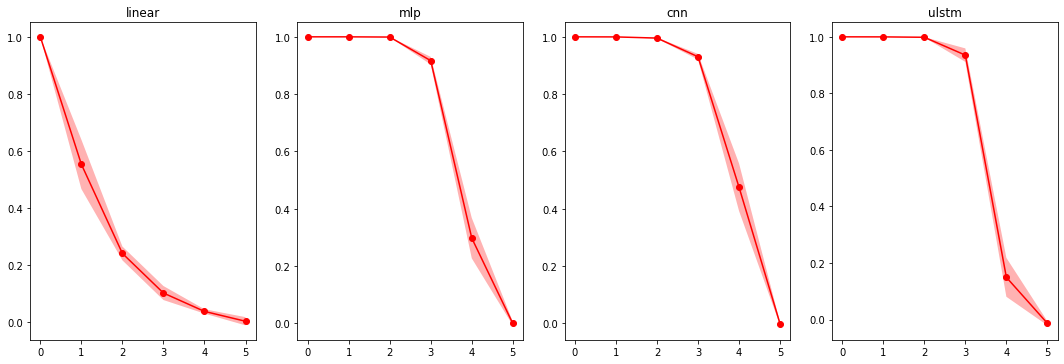

In [13]:
fig,ax = plt.subplots(nrows=1, ncols=4,figsize = (15, 5))
fig.tight_layout()
for index, axis in enumerate(ax.ravel()): 
    model_name    = model_names[index]
    model_results = results[model_name]

    model_mean    = np.mean(model_results, axis=1)
    model_std     = np.std(model_results, axis=1)
    pearson_mean  = [model_mean[k_val][2] for k_val in range(model_results.shape[0])]
    mse_mean      = [model_mean[k_val][1] for k_val in range(model_results.shape[0])]
    spearman_mean = np.array([model_mean[k_val][3] for k_val in range(model_results.shape[0])])
    spearman_std  = np.array([model_std[k_val][3] for k_val in range(model_results.shape[0])])
    x = range(SEQ_LEN)
    #r2_mean       = [model_mean[k_val][0] for k_val in range(model_results.shape[0])]
    #axis.plot(pearson_mean, c='k')
    axis.plot(spearman_mean, c='r', marker='o')
    axis.fill_between(x, spearman_mean-spearman_std, spearman_mean+spearman_std,facecolor='r', alpha=0.3)
    axis.set_title(model_name)
    #axis.plot(r2_mean, c='b')
    


## Latent representation results

In [19]:

def get_latent_representationz(model, model_name,  x_data):
    # Variable to store the final layer activation
    final_activation = None

    # Define a forward hook callback function to capture the output
    def forward_hook(module, input, output):
        nonlocal final_activation  # Use nonlocal to modify the variable outside the inner function
        final_activation = output

    # Attach the hook to the final layer of the model
    if model_name == 'mlp': 
        final_layer = model.fc_layers[-1]
        hook_handle = final_layer.register_forward_hook(forward_hook)
    elif model_name == 'cnn': 
        final_layer = list(model.children())[-2] #gets the final MaxPool1d layer 
        hook_handle = final_layer.register_forward_hook(forward_hook)
    elif model_name == 'ulstm': 
        hook_handle = model.lstm.register_forward_hook(forward_hook)
    else: 
        raise Exception('Model name not recognised.')

    # Run a forward pass
    _ = model(x_data)

    # Remove the hook to prevent side effects
    hook_handle.remove()

    if model_name =='ulstm': 
        final_activation = final_activation[0][:, -1, :]
    # Return the captured activation
    return final_activation.detach()


In [15]:
landscapes_as_tensor = [[torch.from_numpy(i).to(torch.float32) for i in j[0]] for j in splits]
flattened_landscapes = [[i.reshape(i.shape[0], i.shape[1]*i.shape[2]) for i in j[0]] for j in splits]

In [16]:
degree=30

In [21]:
mlp_latent_reps = [[get_latent_representation(mlp_models[i][j],'mlp', landscapes_as_tensor[i][j]) for j in range(N_REPLICATES)] for i in range(len(mlp_models))]
cnn_latent_reps = [[get_latent_representation(cnn_models[i][j],'cnn', landscapes_as_tensor[i][j]) for j in range(N_REPLICATES)] for i in range(len(cnn_models))]


In [20]:
ulstm_latent_reps = [[get_latent_representationz(ulstm_models[i][j],'ulstm', landscapes_as_tensor[i][j]) for j in range(N_REPLICATES)] for i in range(len(ulstm_models))]

In [23]:
knn_landscapes = [[kneighbors_graph(flattened_landscapes[i][j], n_neighbors=degree, n_jobs=-1) for j in range(N_REPLICATES) ] for i in range(SEQ_LEN)]

In [24]:
knn_mlp_layers = [[kneighbors_graph(mlp_latent_reps[i][j], n_neighbors=degree, n_jobs=-1) for j in range(N_REPLICATES) ]for i in range(len(mlp_latent_reps))]

In [26]:
knn_cnn_layers = [[kneighbors_graph(cnn_latent_reps[i][j].squeeze(), n_neighbors=degree, n_jobs=-1) for j in range(N_REPLICATES) ]for i in range(len(cnn_latent_reps))]

In [27]:
knn_ulstm_layers = [[kneighbors_graph(ulstm_latent_reps[i][j], n_neighbors=degree, n_jobs=-1) for j in range(N_REPLICATES) ]for i in range(len(ulstm_latent_reps))]

In [29]:
#make the adjacencies symmetrical
knn_nk_landscapes_symA = [[A.maximum(A.T) for A in j] for j in knn_landscapes]
knn_mlp_layers_symA = [[A.maximum(A.T) for A in j] for j in knn_mlp_layers]
knn_cnn_layers_symA = [[A.maximum(A.T) for A in j] for j in knn_cnn_layers]
knn_ulstm_layers_symA = [[A.maximum(A.T) for A in j] for j in knn_ulstm_layers]

In [208]:
#check if all entries of A positive
"""
for k in knn_nk_landscapes_symA: 
    for A in k: 
        min_A = A.min()
        if min_A < 0:
            print(f"Minimum value in adjacency matrix A: {min_A}")
            raise ValueError("Adjacency matrix contains negative values.")
        else:
            print("Adjacency matrix contains no negative values.")
        if (A != A.T).nnz == 0:
            print("Adjacency matrix is symmetric.")
        else:
            print("Adjacency matrix is not symmetric.")
            # Optionally print the number of asymmetric entries
            asymmetric_entries = (A != A.T).nnz
            print(f"Number of asymmetric entries: {asymmetric_entries}")
        if not np.isfinite(A.data).all():
            raise ValueError("Adjacency matrix contains NaN or Inf values.")
        else:
            print("Adjacency matrix contains no NaN or Inf values.")"""


Adjacency matrix contains no negative values.
Adjacency matrix is symmetric.
Adjacency matrix contains no NaN or Inf values.
Adjacency matrix contains no negative values.
Adjacency matrix is symmetric.
Adjacency matrix contains no NaN or Inf values.
Adjacency matrix contains no negative values.
Adjacency matrix is symmetric.
Adjacency matrix contains no NaN or Inf values.
Adjacency matrix contains no negative values.
Adjacency matrix is symmetric.
Adjacency matrix contains no NaN or Inf values.
Adjacency matrix contains no negative values.
Adjacency matrix is symmetric.
Adjacency matrix contains no NaN or Inf values.
Adjacency matrix contains no negative values.
Adjacency matrix is symmetric.
Adjacency matrix contains no NaN or Inf values.
Adjacency matrix contains no negative values.
Adjacency matrix is symmetric.
Adjacency matrix contains no NaN or Inf values.
Adjacency matrix contains no negative values.
Adjacency matrix is symmetric.
Adjacency matrix contains no NaN or Inf values.


In [213]:
#check laplacians
"""
for k in knn_mlp_laplacians: 
    for L in k: 
        if (L != L.T).nnz == 0:
            print("Laplacian matrix is symmetric.")
        else:
            print("Laplacian matrix is not symmetric.")"""


Laplacian matrix is symmetric.
Laplacian matrix is symmetric.
Laplacian matrix is symmetric.
Laplacian matrix is symmetric.
Laplacian matrix is symmetric.
Laplacian matrix is symmetric.
Laplacian matrix is symmetric.
Laplacian matrix is symmetric.
Laplacian matrix is symmetric.
Laplacian matrix is symmetric.
Laplacian matrix is symmetric.
Laplacian matrix is symmetric.
Laplacian matrix is symmetric.
Laplacian matrix is symmetric.
Laplacian matrix is symmetric.
Laplacian matrix is symmetric.
Laplacian matrix is symmetric.
Laplacian matrix is symmetric.
Laplacian matrix is symmetric.
Laplacian matrix is symmetric.
Laplacian matrix is symmetric.
Laplacian matrix is symmetric.
Laplacian matrix is symmetric.
Laplacian matrix is symmetric.


In [33]:
def adjacency_to_diag_laplacian(A): 
    """
    Calculates degree and Laplacian matrices from an adjacency matrix.  
    
    Args: 
        A (scipy sparse matrix): adjacency of graph
    Returns: 
        D (scipy sparse matrix): degree matrix of graph
        L (scipy sparse matrix): Laplacian matrix of graph
    """
    # Check for negative entries in A
    if A.min() < 0:
        raise ValueError("Adjacency matrix has negative values.")
    
    # Ensure A is symmetric
    if (A != A.T).nnz != 0:
        raise ValueError("Adjacency matrix is not symmetric for an undirected graph.")
    
    degrees = np.array(A.sum(axis=1)).flatten()
    # Check for negative degrees
    if degrees.min() < 0:
        raise ValueError("Degree matrix has negative values.")
    
    D = diags(degrees, format='csr')
    L = D - A
    return D, L

def sparse_dirichlet(L, f): 
    """
    Calculates the Dirichlet energy of a signal f over a graph. 
    
    Args: 
        L (scipy sparse matrix): graph Laplacian
        f (np array): signal over graph
    """
    f = f.astype('float64')
    L = L.astype('float64')

    #min_eigval = eigsh(L, k=1, which='SA', return_eigenvectors=False)[0]
    #if min_eigval < -1e-10:
        #raise ValueError("Laplacian matrix is not positive semi-definite.")

    
    Lf = L.dot(f)
    fLf = f.T @ Lf  # Ensures matrix-vector product

    # Allow for minor numerical errors
    tol = 1e-10
    if fLf < -tol:
        raise ValueError(f"Dirichlet energy is negative: {fLf}")

    return fLf.item()


In [34]:
#compute laplacians
knn_nk_laplacians = [[adjacency_to_diag_laplacian(i)[1] for i in j] for j in knn_nk_landscapes_symA]
knn_mlp_laplacians = [[adjacency_to_diag_laplacian(i)[1] for i in j] for j in knn_mlp_layers_symA]
knn_cnn_laplacians = [[adjacency_to_diag_laplacian(i)[1] for i in j] for j in knn_cnn_layers_symA]
knn_ulstm_laplacians = [[adjacency_to_diag_laplacian(i)[1] for i in j] for j in knn_ulstm_layers_symA]

In [35]:
landscapes_y       = [[i.fitnesses.reshape(-1,1) for i in j] for j in landscapes]

In [36]:
#compute dirichlet energies
nk_dirichlets  = np.array([[sparse_dirichlet(knn_nk_laplacians[i][j], landscapes_y[i][j]) for j in range(N_REPLICATES)] for i in range(SEQ_LEN)])
mlp_dirichlets = np.array([[sparse_dirichlet(knn_mlp_laplacians[i][j], landscapes_y[i][j]) for j in range(N_REPLICATES)] for i in range(SEQ_LEN)])
cnn_dirichlets = np.array([[sparse_dirichlet(knn_cnn_laplacians[i][j], landscapes_y[i][j]) for j in range(N_REPLICATES)] for i in range(SEQ_LEN)])
ulstm_dirichlets = np.array([[sparse_dirichlet(knn_ulstm_laplacians[i][j], landscapes_y[i][j]) for j in range(N_REPLICATES)] for i in range(SEQ_LEN)])

In [37]:
nk_dirichlets_means, nk_dirichlets_std = np.mean(nk_dirichlets, axis=1), np.std(nk_dirichlets, axis=1)
mlp_dirichlets_means, mlp_dirichlets_std = np.mean(mlp_dirichlets, axis=1), np.std(mlp_dirichlets, axis=1)
cnn_dirichlets_means, cnn_dirichlets_std = np.mean(cnn_dirichlets, axis=1), np.std(cnn_dirichlets, axis=1)
ulstm_dirichlets_means, ulstm_dirichlets_std = np.mean(ulstm_dirichlets, axis=1), np.std(ulstm_dirichlets, axis=1)


In [182]:
for k in landscapes_y: 
    for y in k: 
        print(y.shape)
        assert np.isfinite(y.ravel()).all(), "Signal vector contains NaN or Inf."

(46656, 1)


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [179]:
[[assert np.isfinite(i).all(), "Signal vector contains NaN or Inf." for i in j] for j in landscapes]

SyntaxError: invalid syntax (2078721937.py, line 1)

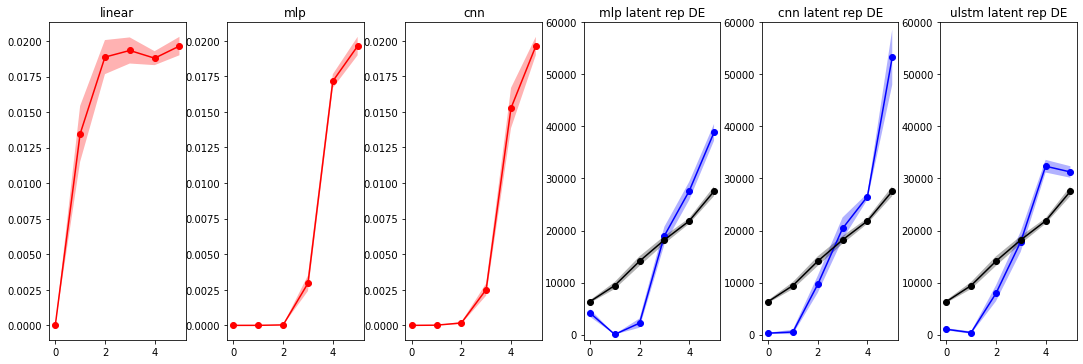

In [39]:
fig,ax = plt.subplots(nrows=1, ncols=6, figsize=(15,5))
fig.tight_layout()
for index, axis in enumerate(ax.ravel()): 

    if index <3: 
        model_name    = model_names[index]
        model_results = results[model_name]
    
        model_mean    = np.mean(model_results, axis=1)
        model_std     = np.std(model_results, axis=1)
        pearson_mean  = [model_mean[k_val][2] for k_val in range(model_results.shape[0])]
        mse_mean      = np.array([model_mean[k_val][1] for k_val in range(model_results.shape[0])])
        mse_std       = np.array([model_std[k_val][1] for k_val in range(model_results.shape[0])])
        spearman_mean = np.array([model_mean[k_val][3] for k_val in range(model_results.shape[0])])
        spearman_std  = np.array([model_std[k_val][3] for k_val in range(model_results.shape[0])])        
        
        x = range(SEQ_LEN)
        #r2_mean       = [model_mean[k_val][0] for k_val in range(model_results.shape[0])]
        #axis.plot(pearson_mean, c='k')
        axis.plot(mse_mean, c='r', marker='o')
        axis.fill_between(x, mse_mean-mse_std, mse_mean+mse_std,facecolor='r', alpha=0.3)
        axis.set_title(model_name)

    elif index == 3: 
        axis.plot(mlp_dirichlets_means, c='b', marker='o')
        axis.fill_between(x, mlp_dirichlets_means-mlp_dirichlets_std, mlp_dirichlets_means+mlp_dirichlets_std,facecolor='b', alpha=0.3)
        axis.plot(nk_dirichlets_means, c='k', marker='o')
        axis.fill_between(x, nk_dirichlets_means-nk_dirichlets_std, nk_dirichlets_means+nk_dirichlets_std,facecolor='k', alpha=0.3)

        axis.set_title('mlp latent rep DE')
        axis.set_ylim(-1000,60000)
    elif index==4: 
        axis.plot(cnn_dirichlets_means, c='b', marker='o')
        axis.fill_between(x, cnn_dirichlets_means-cnn_dirichlets_std, cnn_dirichlets_means+cnn_dirichlets_std,facecolor='b', alpha=0.3)
        axis.plot(nk_dirichlets_means, c='k', marker='o')
        axis.fill_between(x, nk_dirichlets_means-nk_dirichlets_std, nk_dirichlets_means+nk_dirichlets_std,facecolor='k', alpha=0.3)

        axis.set_title('cnn latent rep DE')
        axis.set_ylim(-1000,60000)
    elif index==5: 
        axis.plot(ulstm_dirichlets_means, c='b', marker='o')
        axis.fill_between(x, ulstm_dirichlets_means-ulstm_dirichlets_std, ulstm_dirichlets_means+ulstm_dirichlets_std,facecolor='b', alpha=0.3)
        axis.plot(nk_dirichlets_means, c='k', marker='o')
        axis.fill_between(x, nk_dirichlets_means-nk_dirichlets_std, nk_dirichlets_means+nk_dirichlets_std,facecolor='k', alpha=0.3)

        axis.set_title('ulstm latent rep DE')
        axis.set_ylim(-1000,60000)
    
    